In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from pycocotools.coco import COCO
import numpy as np
import torch

In [10]:
import os
def clean_model_cache(output_dir):
    filenms=os.listdir(output_dir)
    for file in filenms:
        if 'model' in file and 'final' not in file:
            os.remove(output_dir+file)

In [6]:
cdir

'/home/r7user3/ZhangHT/github/maskrcnn-benchmark/logs/dsbw_12_28/inference/coco_dsbw_test./'

In [12]:
annFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/datasets/dsbw/test.json'
File='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/datasets/dsbw/'

In [13]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [14]:
Id=0
imgIds=coco.getImgIds()
masksgt=[]
for imgId in imgIds:
    annIds=coco.getAnnIds(imgIds=imgId)
    anns=coco.loadAnns(annIds)
    maskgt=[coco.annToMask(ann) for ann in anns]
    masksgt.append((np.sum(maskgt,0)>0).astype(np.uint8))

In [15]:
imgsInfo=coco.loadImgs(imgIds)
whs=[(img['width'],img['height']) for img in imgsInfo]

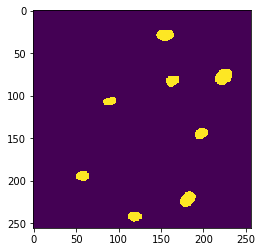

In [16]:
plt.imshow(masksgt[9])

In [17]:
predictions=torch.load('./predictions.pth')

In [18]:
masksdt=[]
for i,prediction in enumerate(predictions):
    prediction=prediction.resize(whs[i])
    maskdt=prediction.get_field('mask')
    masker=Masker()
    if list(maskdt.shape[-2:]) != list(whs[i][::-1]):
        maskdt = masker(maskdt.expand(1, -1, -1, -1, -1), prediction)
        maskdt = maskdt[0]
    maskdt=maskdt.numpy().sum((0,1))
    maskdt=(maskdt>0).astype(np.uint8)
    masksdt.append(maskdt)

In [19]:
whsdt=[tuple(maskdt.shape[::-1]) for maskdt in masksdt]
whsdt==whs

True

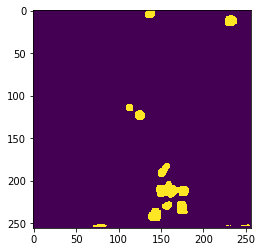

In [20]:
plt.imshow(masksdt[4])

In [ ]:
# # add your statistics here, '_' denotes the unwrapped one
# def _dice(maskgt,maskdt):
#     intersect=np.logical_and(maskdt,maskgt).sum()
#     dice=2*intersect/(maskdt.sum()+maskgt.sum())
#     return dice

# class EvalMetric(object):
#     def __init__(self,masksgt,masksdt):
#         self.masksgt=masksgt
#         self.masksdt=masksdt
        
#     def __len__(self):
#         if len(self.masksgt)==len(self.masksdt):
#             return len(self.masksgt)
#         else:
#             raise ValueError('The length of the ground truth and detections differs!')

#     def wrapper(self,func):
#         results=[]
#         for maskgt,maskdt in zip(self.masksgt,self.masksdt):
#             if isinstance(maskdt,np.ndarray) and isinstance(maskgt,np.ndarray):
#                 results.append(func(maskgt,maskdt))
#             else:
#                 raise TypeError('"maskdt" or "maskgt" should be np.ndarray, but get {} and {}.' \
#                                 .format(type(maskdt),type(maskgt)))
                                
#         return results
    
#     @property
#     def mean_dice(self):
#         return np.mean(self.wrapper(_dice))

True

In [21]:
from maskrcnn_benchmark.utils.validation import EvalMetric
eval_metric=EvalMetric(masksgt,masksdt)
eval_metric.mean_dice

0.7374394698566026

In [ ]:
from maskrcnn_benchmark.utils.earlystop import EarlyStopping

In [ ]:
def do_train(
    model,
    data_loader,
    optimizer,
    scheduler,
    checkpointer,
    device,
    checkpoint_period,
    arguments,
    cfg,
    distributed=False,
):
    logger = logging.getLogger("maskrcnn_benchmark.trainer")
    logger.info("Start training")
    meters = MetricLogger(delimiter="  ")
    max_iter = len(data_loader)
    start_iter = arguments["iteration"] # 0 at start
    
    ######## optional for evaluation ########
    if cfg.DATASETS.VAL:
        # load masks
        _,ann_file=DatasetCatalog.DATASETS[cfg.DATASETS.VAL[0]].values()
        data_dir=DatasetCatalog.DATA_DIR
        annFile=data_dir+'/'+ann_file
        
        coco=COCO(annFile)
        imgIds=coco.getImgIds()
        print('Loading the masks...')
        masksgt=[]
        for imgId in imgIds:
            annIds=coco.getAnnIds(imgIds=imgId)
            anns=coco.loadAnns(annIds)
            maskgt=[coco.annToMask(ann) for ann in anns]
            masksgt.append((np.sum(maskgt,0)>0).astype(np.uint8))
        imgsInfo=coco.loadImgs(imgIds)
        whs=[(img['width'],img['height']) for img in imgsInfo]
        print('Loading Complete!')
        
        # conifgurations for loading the data
        iou_types = ("bbox",)
        if cfg.MODEL.MASK_ON:
            iou_types = iou_types + ("segm",)
            dataset_name = cfg.DATASETS.VAL
        if len(dataset_name)>1: # TODO: add support for multiple datasets
            raise ValueError('Only support the single validation set, but get {}!'.format(len(dataset_name)))
        data_loader_val = make_data_loader(cfg, is_train=False, is_val=True, is_distributed=distributed)
        
        ## early stop ##
        if cfg.PATIENCE:
            early_stopping = EarlyStopping(patience=cfg.PATIENCE, verbose=True)
    ##########################################
    
    model.train() # begin training
    start_training_time = time.time() 
    end = time.time()
    
    for iteration, (images, targets, _) in enumerate(data_loader, start_iter):
        data_time = time.time() - end
        
        # add ignore 
        if len(targets[0]) < 1:
            print('num_boxes: ', len(targets[0]))
            continue
        
        iteration = iteration + 1
        arguments["iteration"] = iteration
       
        
        scheduler.step()

        images = images.to(device)
        targets = [target.to(device) for target in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_loss_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        meters.update(loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        batch_time = time.time() - end
        end = time.time()
        meters.update(time=batch_time, data=data_time)

        eta_seconds = meters.time.global_avg * (max_iter - iteration)
        eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
        
        # give all the information
        if iteration % 20 == 0 or iteration == max_iter:
            logger.info(
                meters.delimiter.join(
                    [
                        "eta: {eta}",
                        "iter: {iter}",
                        "{meters}",
                        "lr: {lr:.6f}",
                        "max mem: {memory:.0f}",
                    ]
                ).format(
                    eta=eta_string,
                    iter=iteration,
                    meters=str(meters),
                    lr=optimizer.param_groups[0]["lr"],
                    memory=torch.cuda.max_memory_allocated() / 1024.0 / 1024.0,
                )
            )
        if iteration % checkpoint_period == 0:
            ################## add evaluation here #####################
            if cfg.DATASETS.VAL:
                predictions=inference(
                                        model.module,
                                        data_loader_val,
                                        dataset_name=dataset_name,
                                        iou_types=iou_types,
                                        box_only=cfg.MODEL.RPN_ONLY,
                                        device=cfg.MODEL.DEVICE,
                                        expected_results=cfg.TEST.EXPECTED_RESULTS,
                                        expected_results_sigma_tol=cfg.TEST.EXPECTED_RESULTS_SIGMA_TOL,
                                        only_predictions=True
                                    )
                synchronize()
                model.train() # reset training
                
                print('Loading the predictions...')
                masksdt=[]
                for i,prediction in enumerate(predictions):
                    prediction=prediction.resize(whs[i])
                    maskdt=prediction.get_field('mask')
                    masker=Masker()
                    if list(maskdt.shape[-2:]) != list(whs[i][::-1]):
                        maskdt = masker(maskdt.expand(1, -1, -1, -1, -1), prediction)
                        maskdt = maskdt[0]
                    maskdt=maskdt.numpy().sum((0,1))
                    maskdt=(maskdt>0).astype(np.uint8)
                    masksdt.append(maskdt)
                print('Loading Complete!')
                eval_metric=EvalMetric(masksgt,masksdt)
                mean_dice=eval_metric.mean_dice
                logger.info('The mean dice coefficient: {}'.format(mean_dice))
                
                ## early stop ##
                if 'early_stopping' in dir():
                    early_stopping(mean_dice,logger)

                    if early_stopping.early_stop:
                        logger.info('Early stopping')
                        checkpointer.save("model_final", **arguments)
                        break
                    else:
                        checkpointer.save("model_{:07d}".format(iteration), **arguments)
            else:
                checkpointer.save("model_{:07d}".format(iteration), **arguments)
            #############################################################
            
            
        if iteration == max_iter:
            checkpointer.save("model_final", **arguments)

    total_training_time = time.time() - start_training_time
    total_time_str = str(datetime.timedelta(seconds=total_training_time))
    logger.info(
        "Total training time: {} ({:.4f} s / it)".format(
            total_time_str, total_training_time / (max_iter)
        )
    )
